# Import

In [2]:
# Download font when you run this notebook in Colab

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [89]:
import re
import datetime
from collections import Counter
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.patches as patches
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

%matplotlib inline

plt.rc('font', family='NanumGothic') 

# Load Dataset

In [5]:
youtube = pd.read_csv('dataset/k_youtube_datasets.csv')
youtube.head()

,url,vid_name,hashtags,views,likes,upload_date,channel_name,channel_subs
0,https://www.youtube.com/watch?v=NgEk5DFcAbA,"""한국 미쳤나?"" 결승선 통과하는 순간 1초전 카메라에 잡힌 곽윤기 표정 공개되자 ...",#해외반응 #일본반응 #외국인반응,208990,NaN,2022. 2. 12.,클립튜브,구독자 24.9만명
1,https://www.youtube.com/watch?v=deimT6UupoE,금메달 수상소감중 황대헌의 예상치 못한 참격에 린샤오쥔(임효준) 멘탈 나가버린 이유,#해외반응 #일본반응 #외국인반응,242894,NaN,2022. 2. 11.,클립튜브,구독자 24.9만명
2,https://www.youtube.com/watch?v=hrvu3jhp43k,"""한국에서 저걸 뭐라 부르는줄 알아?"" 황대헌 금메달 확정되는 순간 5초전 카메라에...",#해외반응 #일본반응 #외국인반응,950227,NaN,2022. 2. 10.,클립튜브,구독자 24.9만명
3,https://www.youtube.com/watch?v=JxUlSgHLxNo,"결국 심판 시작됐다 ""중국 메달조작 3인방 초비상 사태"" 상상도 못한 상황 닥치자 ...",#해외반응 #일본반응 #외국인반응,1132426,NaN,2022. 2. 9.,클립튜브,구독자 24.9만명
4,https://www.youtube.com/watch?v=Lfs9P3Atuo8,"""80억 인류가 심판했다"" 중국인과 붙는 순간 무더기 실격 참다못한 외국선수들 떠나...",#해외반응 #일본반응 #외국인반응,320065,NaN,2022. 2. 8.,클립튜브,구독자 24.9만명


In [6]:
# 메타 데이터

youtube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9261 entries, 0 to 9260
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           9261 non-null   object
 1   vid_name      9261 non-null   object
 2   hashtags      5503 non-null   object
 3   views         9261 non-null   int64 
 4   likes         6680 non-null   object
 5   upload_date   9261 non-null   object
 6   channel_name  9261 non-null   object
 7   channel_subs  8085 non-null   object
dtypes: int64(1), object(7)
memory usage: 578.9+ KB


# Preprocessing

In [71]:
def preprocess_channel_subs(df: pd.DataFrame) -> pd.DataFrame:
    for i, row in df.iterrows():
        # 숫자만 남기기
        n = float(re.sub('[^0-9.]', '', row['channel_subs'])) 
        
        if '만' in row['channel_subs']:
            n = n * 10000
        elif '천' in row['channel_subs']:
            n = n * 1000
        df.loc[i, 'channel_subs'] = n

    return df

def preprocess_upload_date(df: pd.DataFrame) -> pd.DataFrame:
    df['upload_date'] = pd.to_datetime(df['upload_date'])
    
    # 연도 Column 추가
    df['year'] = df['upload_date'].apply(lambda x: x.year)
    
    # Date index 설정
    df.set_index('upload_date', inplace=True)
    df = df.sort_index()
    return df

def preprocess_hashtags(df: pd.DataFrame) -> pd.DataFrame:
    # hashtag 리스트화
    for i, row in df.iterrows():
        hashtag_lst = row['hashtags'].split(' ')
        
        # 결측치일 경우 빈 리스트
        if '' in hashtag_lst:
            hashtag_lst = []
        
        df.loc[i, 'hashtags'] = str(hashtag_lst)
    return df

def preprocess_all_columns(df: pd.DataFrame) -> pd.DataFrame:
    # 결측치 처리
    df['hashtags'].fillna('', inplace=True)
    df['channel_subs'].fillna('0', inplace=True)
    
    # 최초 공개: 2020. 6. 17. 처리
    df['upload_date'] = df['upload_date'].apply(lambda x: re.sub('[^0-9.]', '', x))
    
    df = preprocess_channel_subs(df)
    df = preprocess_hashtags(df)
    df = preprocess_upload_date(df)
    return df

In [72]:
df = youtube.copy()
df = preprocess_all_columns(df)
df.head()

,url,vid_name,hashtags,views,likes,channel_name,channel_subs,year
upload_date,,,,,,,,
2013-08-11,https://www.youtube.com/watch?v=0emXMyRlJE0,한국말 잘하는 영국남자 + 돼지: Intro,[],1475763,2.7만,영국남자 Korean Englishman,4.6e+06,2013
2013-08-12,https://www.youtube.com/watch?v=GEIIyqRoI8I,한국말 잘하는 영국남자: 런던 + 김치 // What do Londoners thi...,[],1638646,1.7만,영국남자 Korean Englishman,4.6e+06,2013
2013-08-19,https://www.youtube.com/watch?v=Aed8CqyRa_U,영국남자의 모자이야기 + 여우 // Korean Hat + English Fox,[],574197,9.3천,영국남자 Korean Englishman,4.6e+06,2013
2013-08-27,https://www.youtube.com/watch?v=-PWoOMD8OMw,영국남자가 드리는 감사인사 // Thank you from Korean Englis...,[],419907,9.2천,영국남자 Korean Englishman,4.6e+06,2013
2013-08-31,https://www.youtube.com/watch?v=UsIM75T177M,영국남자: 한국말로 런던 투어 // Tour of London's Parks and...,[],1003177,1.2만,영국남자 Korean Englishman,4.6e+06,2013


# EDA

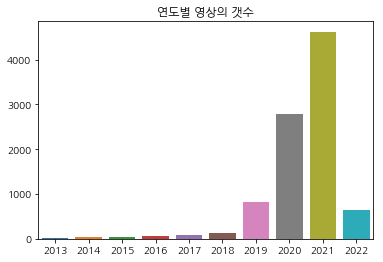

In [73]:
# 연도별 영상의 갯수

temp = df['year'].value_counts()
sns.barplot(temp.index, temp.values)
plt.title('연도별 영상의 갯수')
plt.show()

K-유튜버들의 영상의 수는 2019년 이후로 급격히 증가했다. 그 계기는 2019년 '일본불매운동'이었다. 구글 트렌드를 조사한 결과 역시 2019년에 일본불매운동에 대한 검색 수가 급격히 오른 모습을 보였다.

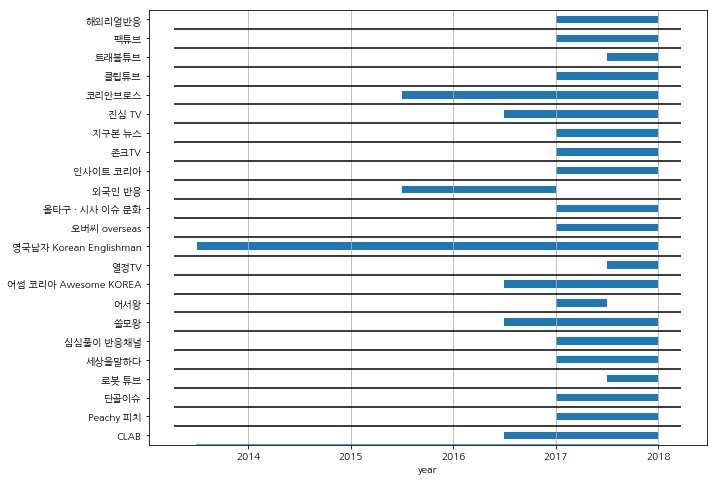

In [74]:
# 유튜버들이 영상을 올린 날짜

temp = df.groupby('channel_name')['year'].agg(['min', 'max'])
# min_date = dates.date2num(temp['min'])
# max_date = dates.date2num(temp['max'])


def plot_rect(data, delta=0.4):
    """data is a dictionary, {"Label":(low,hi), ... }
    return a drawing that you can manipulate, show, save etc"""

    yspan = len(data)
    yplaces = [.5+i for i in range(yspan)]
    ylabels = sorted(data.keys())

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0,yspan))

    # later we'll need the min and max in the union of intervals
    low, hi =  data[ylabels[0]]
    for pos, label in zip(yplaces,ylabels):
        start, end = data[label]
        ax.add_patch(patches.Rectangle((start,pos-delta/2.0),end-start,delta))
        if start<low : low=start
        if end>hi : hi=end

    # little small trick, draw an invisible line so that the x axis
    # limits are automatically adjusted...
    ax.plot((low,hi),(0,0))

    # now get the limits as automatically computed
    xmin, xmax = ax.get_xlim()
    # and use them to draw the hlines in your example
    ax.hlines(range(1,yspan),xmin,xmax)
    # the vlines are simply the x grid lines
    ax.grid(axis='x')
    # eventually return what we have done
    return ax

data = {i:(row['min'], row['max']) for i, row in temp.iterrows()}
ax = plot_rect(data)
# so that we can further manipulate it using the `axes` methods, e.g.
ax.set_xlabel('year')
ax.set_xticklabels(range(2013, 2023))
plt.show()

유튜버들이 영상을 올리기 시작한 연도를 보더라도 오래전부터 유튜버 활동을 해온 '영국남자'를 제외하면 대부분의 유튜버들이 2019년부터 활발하게 영상을 올리기 시작했다는 사실을 알 수 있다. 이를 통해 K-유튜버들은 대부분 애국심으로 꾸준히 유튜브를 운영해온 유튜버들이라기 보단 일본 불매 운동 화제를 타고 조회수를 벌기 위해 유튜브를 시작한 유튜버들이라고 추론할 수 있다.

In [86]:
# 태그 트렌드의 변화

years = [2019, 2020, 2021, 2022]
hashtag_df = pd.DataFrame(index=list(set(df['hashtags'].apply(eval).sum())))

# 모든 연도에 걸쳐 쓰인 태그의 수의 합
hashtag_df['sum'] = np.zeros(len(hashtag_df))

# 태그의 갯수를 해당 연도의 총 영상 수로 나누어 보정

for year in years:
    temp = df[f'{year}-01-01':f'{year + 1}-01-01']
    hashtag_df[f'{year}'] = np.zeros(len(hashtag_df))
    hashtags_counter = Counter(temp['hashtags'].apply(eval).sum())
    for key, value in hashtags_counter.items():
        hashtag_df.loc[key, f'{year}'] = value / len(temp)
        hashtag_df.loc[key, 'sum'] += value

hashtag_df = hashtag_df.sort_values('sum', ascending=False)

# 전년도 값으로 나누어 얼마나 변화했는지 비율 환산

for year in years[:-1]:
    # devide with zero를 피하기 위해 0을 아주 작은 값으로 치환(0,000001)
    hashtag_df[f'{year}'] = hashtag_df[f'{year}'].replace(0, 0.000001) 
    hashtag_df[f'{year}-{year+1}change'] = hashtag_df[f'{year+1}'] / hashtag_df[f'{year}']

hashtag_df.head(50)

,sum,2019,2020,2021,2022,2019-2020change,2020-2021change,2021-2022change
#해외반응,3042.0,0.001217,0.231977,0.442237,0.525268,190.685225,1.906382,1.187752
#외국인반응,1767.0,0.019465,0.137045,0.269704,0.180704,7.040685,1.967998,0.670010
#일본반응,1373.0,0.025547,0.095289,0.195854,0.272588,3.729887,2.055367,1.391792
#한국,1039.0,0.087591,0.175946,0.085727,0.117917,2.008714,0.487233,1.375504
#일본,680.0,0.193431,0.091363,0.051825,0.038285,0.472331,0.567237,0.738738
#외국인,639.0,0.002433,0.043183,0.105377,0.042879,17.748394,2.440213,0.406911
#네티즌반응,216.0,0.000001,0.025339,0.017059,0.101072,25339.043540,0.673228,5.924865
#외국반응,188.0,0.000001,0.014989,0.028072,0.024502,14989.293362,1.872783,0.872847
#중국,172.0,0.023114,0.018915,0.019434,0.015314,0.818325,1.027448,0.787987
#손흥민,165.0,0.001217,0.033191,0.014684,0.004594,27.282655,0.442404,0.312877


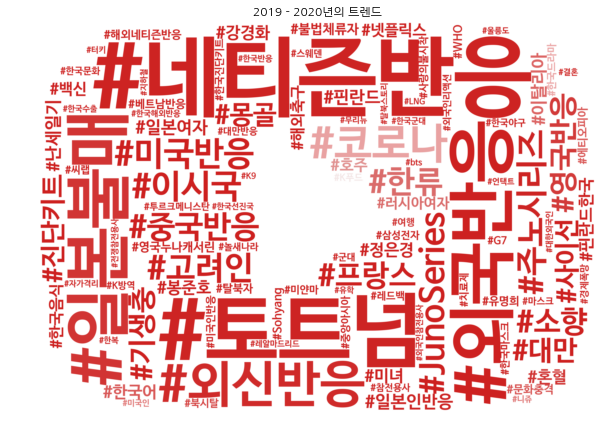

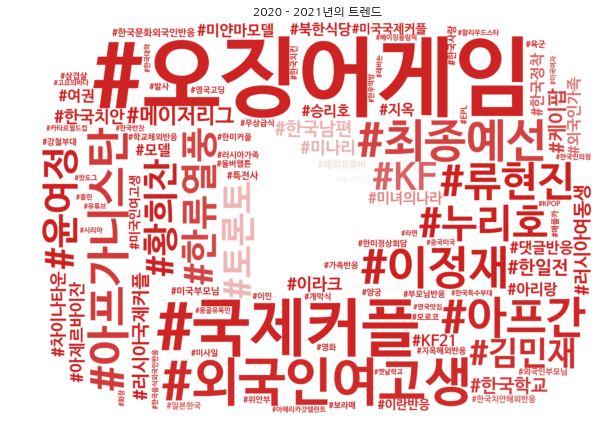

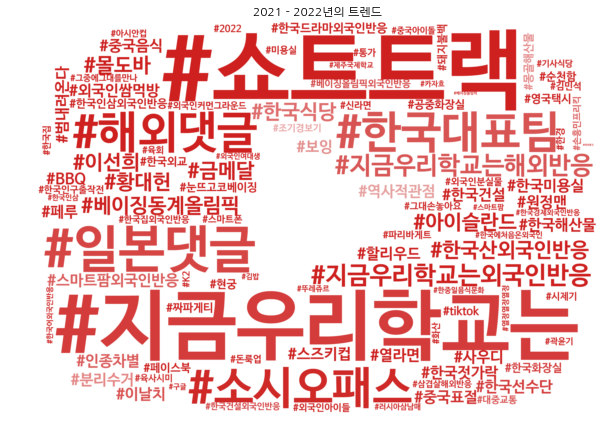

In [92]:
# 변화량을 바탕으로 WordCloud 그리기

# wordcloud mask
icon = Image.open('image/youtube-icon-logo.png')    # 마스크가 될 이미지 불러오기 

mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)


for year in years[:-1]:
    freq = {i:row[f'{year}-{year+1}change'] for i, row in hashtag_df.iterrows()}

    wc = WordCloud(font_path='font/NanumBarunGothicBold.ttf', 
                max_words=100, max_font_size=200,
                scale=4, background_color='white',
                mask=mask,
                random_state=42)

    wc = wc.generate_from_frequencies(freq)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    image_colors = ImageColorGenerator(mask)
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="bilinear")
    plt.title(f'{year} - {year+1}년의 트렌드' )
    plt.show()
